In [ ]:
# Import dependencies
!pip install torchdiffeq
import argparse
import time
import numpy as np
import torchdiffeq
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.io as sio
import matplotlib.pyplot as plt
from numpy import zeros, newaxis
import random
# Adjoint method is not necessary for 
adjoint = False
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')
# Print whether CPU or GPU is used.
#device = torch.device("cuda:0")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Feel free to modify the following line on where to import data. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

tlength = 0 ## Length of time sections
dt = 0.01
timemax = 199-tlength ## length of each time series
## Here we define the Y and Yv as the theta angle and angular velcoity at each time step t. 
nmax =3 
itermax = nmax*2 ## number of time series to be tested
for iter in range(0,itermax): ## we may need to iterate over multiple initial conditions
  randstring = str(iter+1)
  image_array= sio.loadmat('/content/drive/My Drive/mae259b_hw3_f2022/theta_'+randstring+'.mat')
  yiter= image_array['thetaoutall']
  if iter>0:
    Yall= np.vstack([Yall,(yiter[0,1:]-np.mean(yiter[0,1:])).T])
    Yvall = np.vstack([Yvall,np.diff(yiter[0,:]/dt).T])
  else:
    Yall= (yiter[0,1:]-np.mean(yiter[0,1:])).T
    Yvall = np.diff(yiter[0,:]).T/dt
print(Yall.shape)

true_y = np.stack((Yall [0:nmax,:].T, Yvall [0:nmax,:].T), axis =2)

true_y_test= torch.from_numpy(np.stack((Yall [nmax:,:].T, Yvall [nmax:,:].T), axis =2))

print(true_y.shape)
print(true_y_test.shape)

Mounted at /content/drive/
(6, 199)
(199, 3, 2)
torch.Size([199, 3, 2])


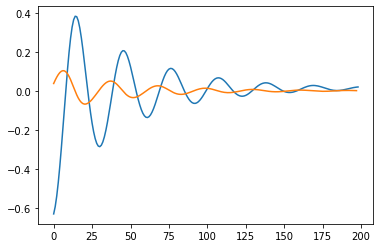

In [ ]:
#plt.plot(true_y[:,0,0],true_y[:,0,1])

plt.plot(true_y[:,0,0]-np.mean(true_y[:,0,0]))

plt.plot(np.diff(true_y[:,0,0]))

In [ ]:
viz = True
test_freq = 100
save_data = False
save_freq = 10
method = 'rk4'
batch_time = 20 # time series data interval (20 time step worth of data) for a single batch 
data_size = timemax# total number of data
batch_size = 5 # number of batches to pick from. size should be 
niters = 5000 # number of iterations.

# Generate ground truth and batch function.
t = torch.linspace(0., 2., data_size).to(device)
t_test = torch.linspace(0., 2., data_size).to(device)

def get_batch_ma(): ## this usually works better for multiple time series
    st = 0 
    s = torch.from_numpy(np.random.choice(np.arange(int(itermax/2), dtype=np.int64), batch_size))
    st = torch.from_numpy(np.random.choice(np.arange(timemax - batch_time, dtype=np.int64), 1, replace=False))
    batch_y0 = true_y[st,s,:]  # (M, D)
    batch_t = t[st:st+batch_time]  # (T)
    batch_y = true_y[st:st+batch_time,s,:]  # (T, M, D)
    batch_y0=torch.from_numpy(batch_y0)
    batch_y=torch.from_numpy(batch_y)

    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

def get_batch():  
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

# Visualize the true and predcited y

def visualize(true_y, pred_y, t, odefunc, itr):

    if viz:
        truedata = true_y.cpu().numpy()[:, 0, 0]
        truedatav = true_y.cpu().numpy()[:, 0, 1]
        import matplotlib
        import matplotlib.pyplot as plt
        fig = plt.figure(figsize=(12, 4), facecolor='white')
        ax_traj = fig.add_subplot(131, frameon=False)
        ax_traj2 = fig.add_subplot(132, frameon=False)
        ax_phase = fig.add_subplot(133, frameon=False)
        ax_traj.cla()
        ax_traj.set_title('Trajectories: displacement')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x')

        ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], 'g-')
        ax_traj.plot(t.cpu().numpy(), pred_y.detach().cpu().numpy()[:, 0, 0], 'b--')
        ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
        #print(str(np.min(truedata)))
        #print(str(np.max(truedata)))
        ax_traj.set_ylim(np.min(truedata)*.9,np.max(truedata)*1.1)
        #ax_traj.legend()

        ax_traj2.cla()
        ax_traj2.set_title('Trajectories: velocity')
        ax_traj2.set_xlabel('t')
        ax_traj2.set_ylabel('v')
        ax_traj2.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 1], 'g-')
        ax_traj2.plot(t.cpu().numpy(), pred_y.detach().cpu().numpy()[:, 0, 1], 'b--')
        ax_traj2.set_xlim(t.cpu().min(), t.cpu().max())
        ax_traj2.set_ylim(np.min(truedatav)*.9,np.max(truedatav)*1.1)
        #ax_traj2.legend()

        ax_phase.cla()
        ax_phase.set_title('Phase Portrait')
        ax_phase.set_xlabel('x')
        ax_phase.set_ylabel('v')
        ax_phase.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'g-')
        ax_phase.plot(pred_y.detach().cpu().numpy()[:, 0, 0], pred_y.detach().cpu().numpy()[:, 0, 1], 'b--')
        ax_phase.set_xlim(np.min(truedata)*.9,np.max(truedata)*1.1)
        ax_phase.set_ylim(np.min(truedatav)*.9,np.max(truedatav)*1.1)

        fig.tight_layout()
        #plt.savefig('png/{:03d}'.format(itr))
        plt.show(block=False)
        
# Create and save data module
def savedata(true_y, pred_y, t, odefunc, itr, append_name):

    if save_data:

        f_true_y = './data/true_'+str(itr)+'_'+append_name+'.txt'
        f_pred_y = './data/pred_'+str(itr)+'_'+append_name+'.txt'
        f_t = './data/t_'+str(itr)+'_'+append_name+'.txt'
        np.savetxt(f_true_y, np.squeeze(true_y.detach().cpu().numpy()), delimiter=",")
        np.savetxt(f_pred_y, np.squeeze(pred_y.detach().cpu().numpy()), delimiter=",")
        np.savetxt(f_t, np.squeeze(t.detach().cpu().numpy()), delimiter=",")
 

Feel free to modify the neural network architecture if needed.

In [ ]:
# Building NN

class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 20),
            nn.Softplus(),
            nn.Linear(20, 20),
            nn.Softplus(),
            nn.Linear(20, 1),
        )
        
        self.register_buffer('coeffMatrix1',torch.tensor([[0,0],[1,0]]).float())
        self.register_buffer('coeffMatrix2',torch.tensor([[0,-1/1],[0,0]]).float())

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        # print("doing forward pass")
        yp = y[...,0:1]
        ypv = y[...,1:]
        #yp.requires_grad_(True) # defines that the gradient is needed to be calculated for the yp
        y.requires_grad_(True) # defines that the gradient is needed to be calculated for the y
        #ypv.requires_grad_(True) # defines that the gradient is needed to be calculated for the yp
        ykappa = 2*torch.tan(y/2)
        ykappa.requires_grad_(True) # defines that the gradient is needed to be calculated for the y

        # print(y.shape)
        out = self.net(y) + self.net(-y)
        #deriv = torch.autograd.grad([out.sum()],[y],retain_graph=True,create_graph=True)
        deriv = torch.autograd.grad([out.sum()],[y],retain_graph=True,create_graph=True)
        #deriv = torch.autograd.grad([deriv0[0]],[y],retain_graph=True,create_graph=True)

        grad = deriv[0]
        #print(grad)
        #print(grad.shape)
        grad1 = deriv[0][:,0:1]
        grad2 = deriv[0][:,1:]

        #print(grad2.shape)
        #print(torch.zeros_like(y).shape)
        if grad is not None: #and gradv is not None:
            return torch.matmul(y,self.coeffMatrix1) + torch.matmul(torch.cat((grad1+grad2,torch.zeros_like(grad1)),-1),self.coeffMatrix2) 

In [ ]:
# Main function
lossall=[]
if __name__ == '__main__':

    ii = 0

    func = ODEFunc().to(device) # transform the tensor fitted to device either CPU and GPU
    optimizer = optim.Adam(func.parameters(), lr=1e-2)
    end = time.time()
    for itr in range(1, niters + 1):
        # print(str(itr) + ": before the iteration")
        optimizer.zero_grad() # initialize
        batch_y0, batch_t, batch_y = get_batch_ma()
        #print(batch_y0)
        #print(batch_t.shape)
        #print(batch_y0.dtype)

        pred_y = odeint(func, batch_y0.to(torch.float32), batch_t).to(device)
        #print(pred_y.shape)

        loss = torch.mean(torch.abs(pred_y - batch_y))
        loss.backward()
        optimizer.step()
        # print(str(itr) + "after backward")
        # print(str(itr) + "after test")
        end = time.time()

        lossall=lossall+[loss.detach().numpy()]

In [ ]:
func.state_dict()
func.parameters

<bound method Module.parameters of ODEFunc(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
)>

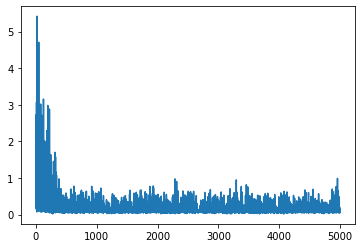

In [ ]:
plt.plot(lossall)


Apply the trained model to predict the test data


torch.Size([199, 1, 2])
torch.Size([199, 3, 2])
Iter 5000 | Test total Loss 1.621561


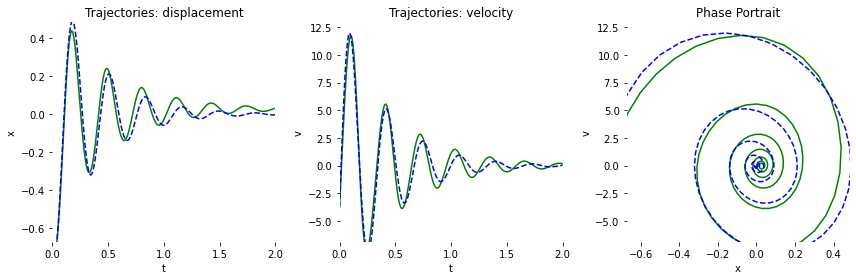

torch.Size([199, 1, 2])
torch.Size([199, 3, 2])
Iter 5000 | Test total Loss 1.751765


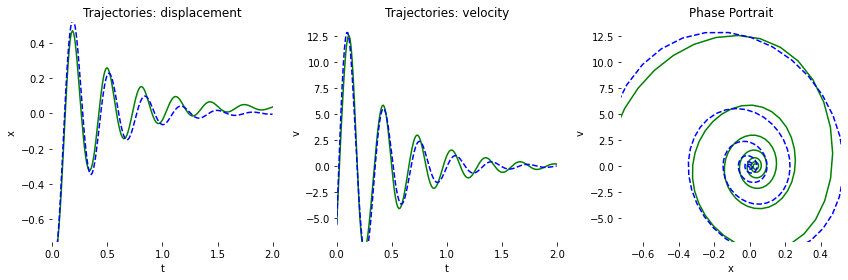

torch.Size([199, 1, 2])
torch.Size([199, 3, 2])
Iter 5000 | Test total Loss 1.897863


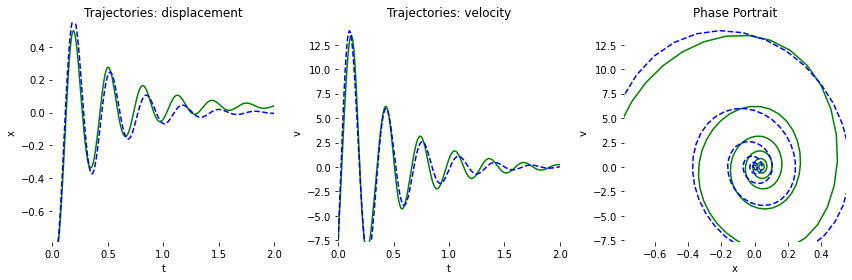

In [ ]:
for testset in range (0,nmax):
  true_y0_test = true_y_test[0,testset:testset+1,:]

  pred_y_test = odeint(func, true_y0_test.to(torch.float32), t_test)
  print(pred_y_test.shape)
  print(true_y_test.shape)
  loss = torch.mean(torch.abs(pred_y_test - true_y_test[:,testset,:]))
  print('Iter {:04d} | Test total Loss {:.6f}'.format(itr, loss.item()))
  visualize(true_y_test[:,testset:testset+1,:], pred_y_test, t_test, func, ii)


In [ ]:
pred_y_test.shape[0]
true_y0_test.shape

torch.Size([1, 2])

Finally let's check the gradient and energy 

In [ ]:
## We now get the 

## over time
gradall = np.zeros((pred_y_test.shape[0], 2)) ## all the forces
outall = np.zeros((pred_y_test.shape[0], 1))
for ii in range(0,pred_y_test.shape[0]):
  yinp = pred_y_test[ii,:,:].to(torch.float32) ## initial velocity

  yinp.requires_grad_(True) # defines that the gradient is needed to be calculated for the y

  out = func.net(yinp) + func.net(-yinp)
  
  #deriv = torch.autograd.grad([out.sum()],[y],retain_graph=True,create_graph=True)
  deriv = torch.autograd.grad([out.sum()],[yinp],retain_graph=True,create_graph=True)
  #deriv = torch.autograd.grad([deriv0[0]],[y],retain_graph=True,create_graph=True)

  grad = deriv[0][0]
  #print(yinp.shape)
  #print(grad.cpu().detach().numpy())
  #print(out[0][0])
  gradall[ii,:]= grad.cpu().detach().numpy()
  outall[ii,:]= out.cpu().detach().numpy()

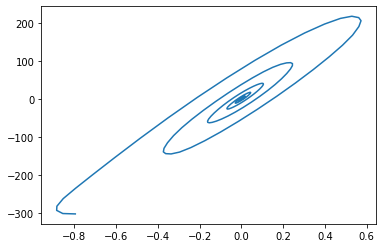

In [ ]:
plt.plot(pred_y_test[:,0,0].cpu().detach().numpy(),gradall[:,0]) ## compare displacement, and the spring force

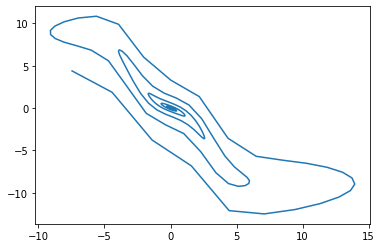

In [ ]:
plt.plot(pred_y_test[:,0,1].cpu().detach().numpy(),gradall[:,1])## compare displacement, and the spring force

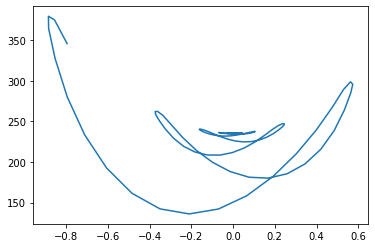

In [ ]:
plt.plot(pred_y_test[:,0,0].cpu().detach().numpy(),outall[:,0])## compare velocity, and the damping force

Not sure why it is not working

In [ ]:
traced_script_module = torch.jit.script(func.to("cpu"))
traced_script_module = traced_script_module.to("cpu")  
traced_script_module.save("./traced_massspring.pt") # saves the trained module to run the trained NN ODE
func.to(device)
modelex = torch.jit.load("/content/traced_deepoderod.pt")
modelex.state_dict()


RuntimeError: ignored